In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
import pickle

%matplotlib inline

#### Bringing in the pickle file

In [5]:
with open('../data/full_race_data.pickle', 'rb') as file:
    full = pickle.load(file)

In [6]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5162881 entries, 0 to 5162880
Data columns (total 29 columns):
 #   Column           Dtype         
---  ------           -----         
 0   track_id         object        
 1   race_date        datetime64[ns]
 2   race_number      int64         
 3   program_number   object        
 4   horse_id         int64         
 5   weight_carried   float64       
 6   jockey           object        
 7   odds             float64       
 8   finishing_place  int64         
 9   horse_name       object        
 10  course_type      object        
 11  track_condition  object        
 12  race_type        object        
 13  purse            int64         
 14  post_time        int64         
 15  latitude         float64       
 16  longitude        float64       
 17  n_lat            float64       
 18  n_lon            float64       
 19  distance_id      int64         
 20  run_up_distance  int64         
 21  trakus_index     int64         

In [8]:
#adding a column that notes the rate distance + runup distance in feet
full['total_dist_ft'] = full['distance_id']*6.6+full['run_up_distance']

#adding a column that indicates each horse's total final cumulative distance run for each race
full['final_dist_ft'] = (
    full
    .groupby(['track_id', 'race_date', 'race_number', 'program_number'])['cum_dist_ft']
    .transform('max')
)
#adding a column that indicates the distance in feet remaining for each horse to run at each trakus index, based on each horse's
#individual cumulative distance run
full['dist_togo_ft'] = full['final_dist_ft']-(full['cum_dist_ft'])
#adding a column that's similar to the one above, but indicates a percent of the distance left to run
full['percent_dist_togo'] = 100-(full['cum_dist_ft']*3/full['final_dist_ft'])*100
#adding a column that translates the odds into a predicted finish value
full['predicted_finish'] = (
    full
    .groupby(['track_id', 'race_date', 'race_number'])['odds']
    .rank(method='dense')
)
#adding a column that indicates the difference between the predicted and actual finish positions
full['finish_dif'] = full['predicted_finish']-full['finishing_place']

In [9]:
#calculating what percentage of horses have the same predicted and actual finish position
(len(full.loc[full['finish_dif'] == 0]
     .drop_duplicates(subset=['track_id', 'race_date', 'race_number','program_number']))
 /
 len(full.drop_duplicates(subset=['track_id', 'race_date', 'race_number','program_number']))
)

0.22530656245788977

Approximately 22.5% of horses have actually finish in the same position they are predicted to

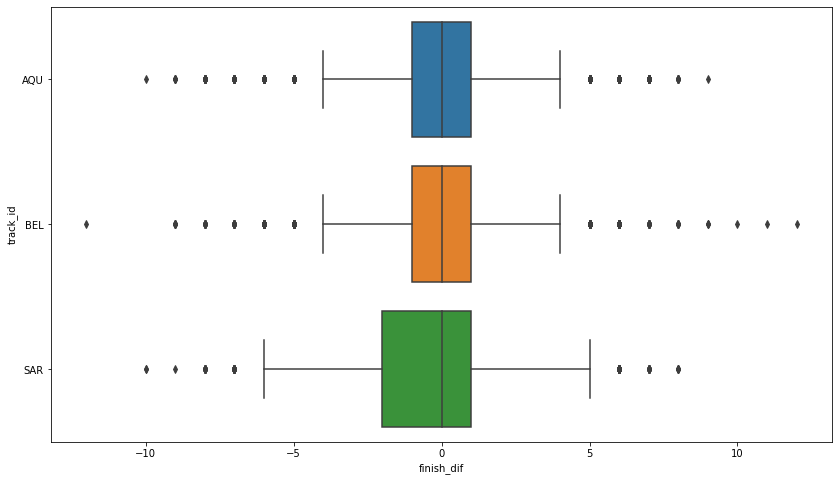

In [10]:
fig, ax = plt.subplots(figsize = (14,8))

sns.boxplot(
            data=full.drop_duplicates(subset=['track_id', 'race_date', 'race_number','program_number']), 
            x='finish_dif', 
            y='track_id', 
            ax=ax
);

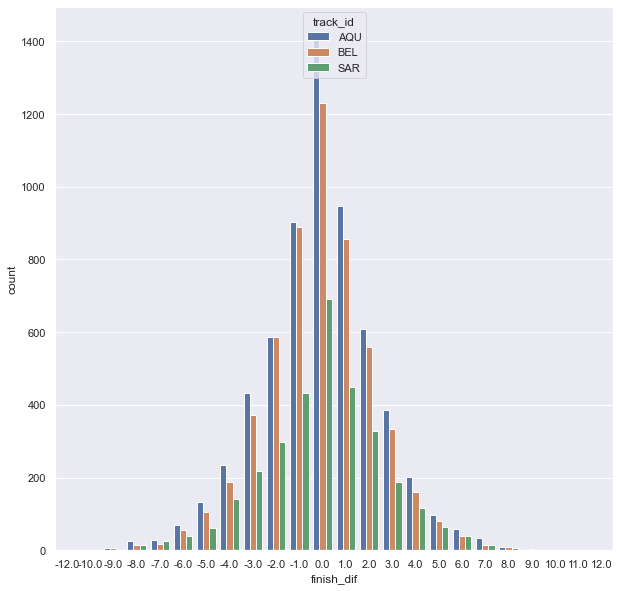

In [11]:
sns.set(rc={"figure.figsize":(10, 10)})

sns.countplot(
            data=full.drop_duplicates(subset=['track_id', 'race_date', 'race_number','program_number']), 
            x='finish_dif', 
            hue='track_id'
);

In [14]:
full.columns

Index(['track_id', 'race_date', 'race_number', 'program_number', 'horse_id',
       'weight_carried', 'jockey', 'odds', 'finishing_place', 'horse_name',
       'course_type', 'track_condition', 'race_type', 'purse', 'post_time',
       'latitude', 'longitude', 'n_lat', 'n_lon', 'distance_id',
       'run_up_distance', 'trakus_index', 'seg_dist_ft', 'seg_speed_ft/s',
       'seg_mph', 'cum_dist_ft', 'avg_speed_ft/s', 'avg_mph',
       'seg_accel_ft/s2', 'total_dist_ft', 'final_dist_ft', 'dist_togo_ft',
       'percent_dist_togo', 'predicted_finish', 'finish_dif'],
      dtype='object')

In [13]:
(
    full
    .drop_duplicates(subset=['track_id', 'race_date', 'race_number','program_number'])
    .corr()

,race_number,horse_id,weight_carried,odds,finishing_place,purse,post_time,latitude,longitude,n_lat,...,cum_dist_ft,avg_speed_ft/s,avg_mph,seg_accel_ft/s2,total_dist_ft,final_dist_ft,dist_togo_ft,percent_dist_togo,predicted_finish,finish_dif
race_number,1.000000,0.095312,0.002818,0.079140,0.151698,0.263127,0.116492,0.094481,0.028769,0.094481,...,0.010222,0.010222,0.010222,NaN,0.114784,0.116331,0.116285,0.009858,0.156152,0.002220
horse_id,0.095312,1.000000,-0.069280,-0.057259,0.048227,0.224084,0.014176,0.386489,0.327554,0.386488,...,0.053252,0.053252,0.053252,NaN,0.102964,0.109214,0.109038,-0.016740,-0.002793,-0.053627
weight_carried,0.002818,-0.069280,1.000000,-0.151858,-0.099652,0.028635,0.004431,0.026945,-0.008211,0.026945,...,-0.000431,-0.000431,-0.000431,NaN,0.094006,0.088669,0.088658,-0.006831,-0.159926,-0.060879
odds,0.079140,-0.057259,-0.151858,1.000000,0.469885,0.000642,0.027344,-0.031858,-0.065350,-0.031858,...,-0.024514,-0.024514,-0.024514,NaN,-0.014991,-0.036516,-0.036437,0.004526,0.767290,0.300734
finishing_place,0.151698,0.048227,-0.099652,0.469885,1.000000,0.019567,0.032101,0.037108,-0.025901,0.037108,...,-0.019574,-0.019574,-0.019574,NaN,-0.005540,-0.072868,-0.072799,-0.007645,0.541387,-0.490986
purse,0.263127,0.224084,0.028635,0.000642,0.019567,1.000000,0.056426,0.115908,0.110265,0.115907,...,0.027874,0.027874,0.027874,NaN,0.305564,0.290294,0.290172,0.007251,0.023839,0.004117
post_time,0.116492,0.014176,0.004431,0.027344,0.032101,0.056426,1.000000,-0.057471,-0.060641,-0.057471,...,-0.030112,-0.030112,-0.030112,NaN,0.069522,0.073028,0.073110,0.012692,0.031589,-0.001038
latitude,0.094481,0.386489,0.026945,-0.031858,0.037108,0.115908,-0.057471,1.000000,0.086924,1.000000,...,-0.064226,-0.064226,-0.064226,NaN,0.003240,0.015948,0.016140,0.014216,0.040017,0.002429
longitude,0.028769,0.327554,-0.008211,-0.065350,-0.025901,0.110265,-0.060641,0.086924,1.000000,0.086924,...,0.243172,0.243172,0.243172,NaN,0.103850,0.100840,0.100092,-0.041835,-0.029670,-0.003496
n_lat,0.094481,0.386488,0.026945,-0.031858,0.037108,0.115907,-0.057471,1.000000,0.086924,1.000000,...,-0.064223,-0.064223,-0.064223,NaN,0.003238,0.015946,0.016138,0.014216,0.040017,0.002429


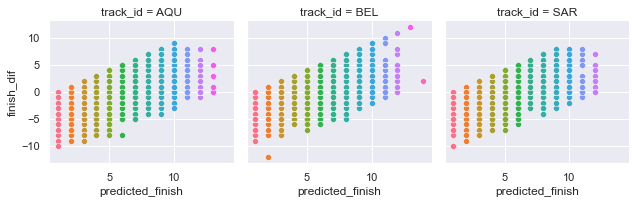

In [18]:
g = sns.FacetGrid(data=full.drop_duplicates(subset=['track_id', 'race_date', 'race_number','program_number']), 
                     col='track_id', 
                     hue='predicted_finish')
g.map(sns.scatterplot, 'predicted_finish', 'finish_dif');

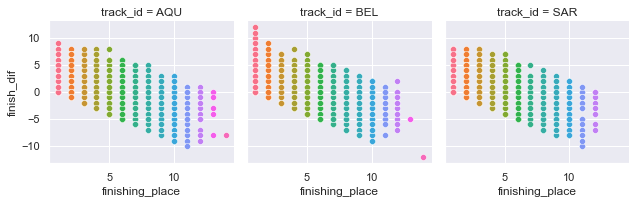

In [17]:
g = sns.FacetGrid(data=full.drop_duplicates(subset=['track_id', 'race_date', 'race_number','program_number']), 
                     col='track_id', 
                     hue='finishing_place')
g.map(sns.scatterplot, 'finishing_place', 'finish_dif');

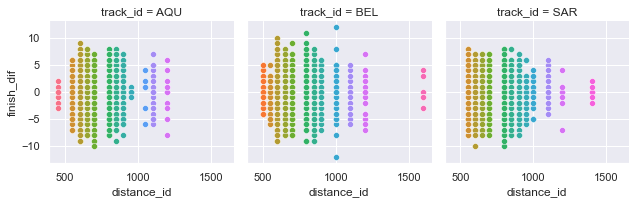

In [22]:
g = sns.FacetGrid(
    data=full.drop_duplicates(subset=['track_id', 'race_date', 'race_number','program_number']),
    col='track_id', 
    hue='distance_id'
                 )
g.map(sns.scatterplot, 'distance_id', 'finish_dif');

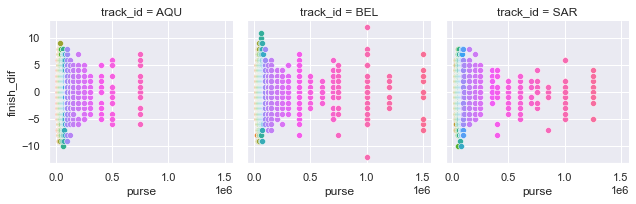

In [24]:
g = sns.FacetGrid(
    data=full.drop_duplicates(subset=['track_id', 'race_date', 'race_number','program_number']),
    col='track_id', 
    hue='purse'
                 )
g.map(sns.scatterplot, 'purse', 'finish_dif');

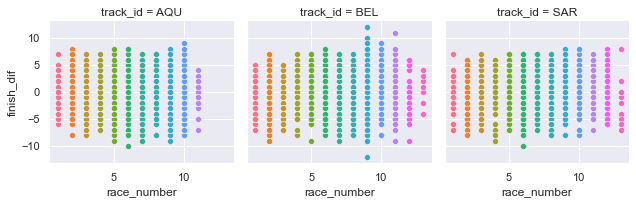

In [25]:
g = sns.FacetGrid(
    data=full.drop_duplicates(subset=['track_id', 'race_date', 'race_number','program_number']),
    col='track_id', 
    hue='race_number'
                 )
g.map(sns.scatterplot, 'race_number', 'finish_dif');

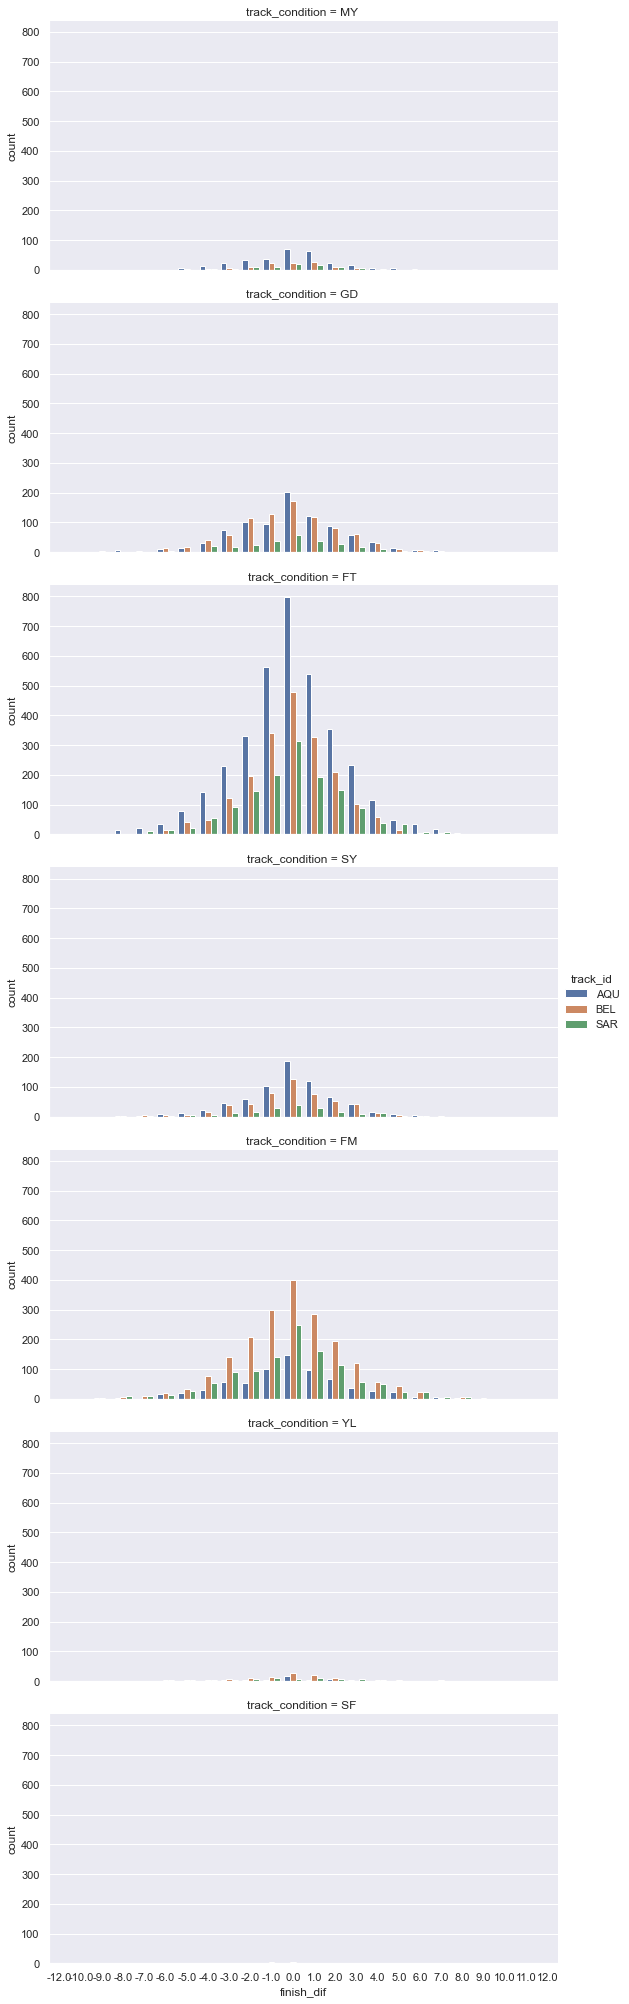

In [80]:
sns.catplot(
    data=full.drop_duplicates(subset=['track_id', 'race_date', 'race_number','program_number']), 
    x="finish_dif", 
    row="track_condition", 
    hue="track_id",
    height=4,
    aspect=2,
    kind='count'
);

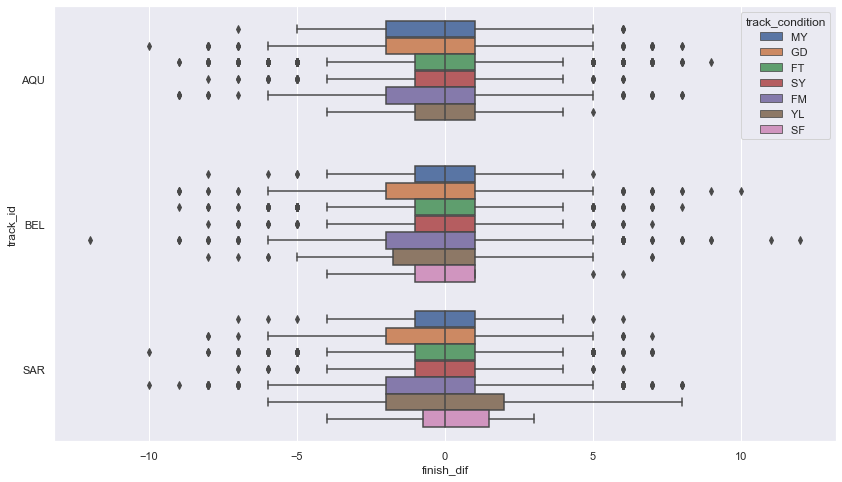

In [41]:
fig, ax = plt.subplots(figsize = (14,8))

sns.boxplot(
            data=full.drop_duplicates(subset=['track_id', 'race_date', 'race_number','program_number']), 
            x='finish_dif', 
            y='track_id', 
            hue='track_condition',
            ax=ax
);

In [65]:
freq_riders = (
    full
    .drop_duplicates(subset=['track_id', 'race_date', 'race_number','program_number'])['jockey']
    .value_counts()
    .loc[lambda x : x>=100]
    .to_frame()
    .reset_index()
    .rename(columns = {'index': 'jockey_name',
                       'jockey' : 'num_races'})
)
freq_riders

,jockey_name,num_races
0,Manuel Franco,1274
1,Dylan Davis,1108
2,Jose Lezcano,990
3,Junior Alvarado,852
4,Irad Ortiz Jr.,802
5,Eric Cancel,721
6,Kendrick Carmouche,714
7,Jose L. Ortiz,702
8,Luis Saez,666
9,Joel Rosario,657


In [71]:
(
    full
    .drop_duplicates(subset=['track_id', 'race_date', 'race_number','program_number'])
    .loc[full['jockey'].isin(freq_riders['jockey_name'])]
    .groupby('jockey')['finish_dif']
    .agg(['count','mean'])
    .sort_values('mean', ascending=False)
)

,count,mean
jockey,,
Heman K. Harkie,226,1.057522
Samuel Camacho Jr.,212,0.891509
Joey R. Martinez,360,0.788889
Harry Hernandez,130,0.723077
Hector Rafael Diaz Jr.,261,0.655172
Benjamin Hernandez,547,0.628885
Luis A. Rodriguez Castro,104,0.586538
Luis R. Reyes,385,0.436364
Eric Cancel,721,0.348128


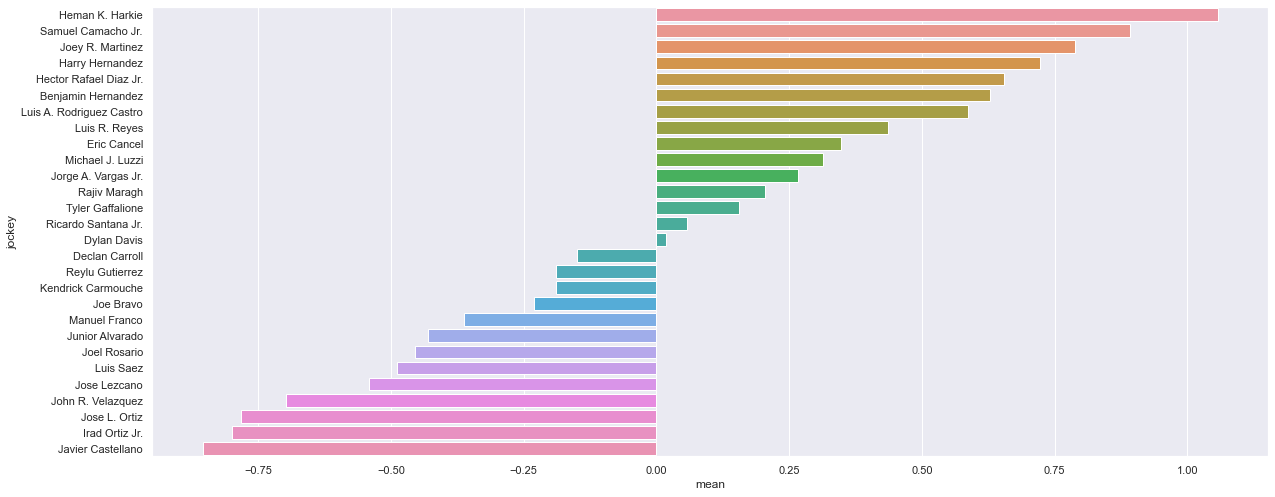

In [75]:
sns.barplot(
     x='mean',
     y='jockey',
     data=(
         full
         .drop_duplicates(subset=['track_id', 'race_date', 'race_number','program_number'])
         .loc[full['jockey'].isin(freq_riders['jockey_name'])]
         .groupby('jockey')['finish_dif']
         .agg(['count','mean'])
         .reset_index()
         .sort_values('mean', ascending=False))
    );

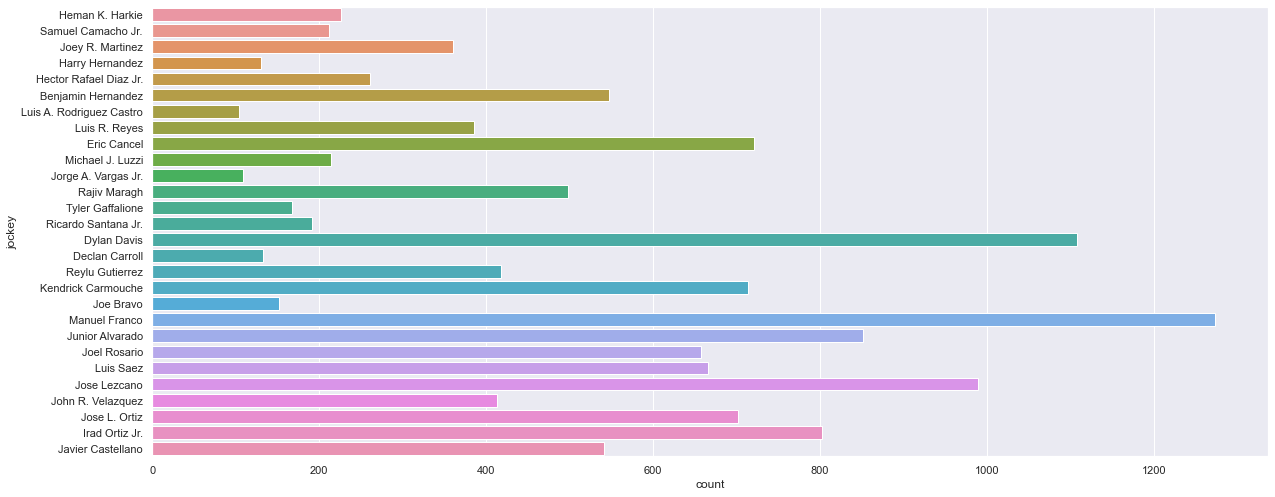

In [76]:
sns.barplot(
     x='count',
     y='jockey',
     data=(
         full
         .drop_duplicates(subset=['track_id', 'race_date', 'race_number','program_number'])
         .loc[full['jockey'].isin(freq_riders['jockey_name'])]
         .groupby('jockey')['finish_dif']
         .agg(['count','mean'])
         .reset_index()
         .sort_values('mean', ascending=False))
    );

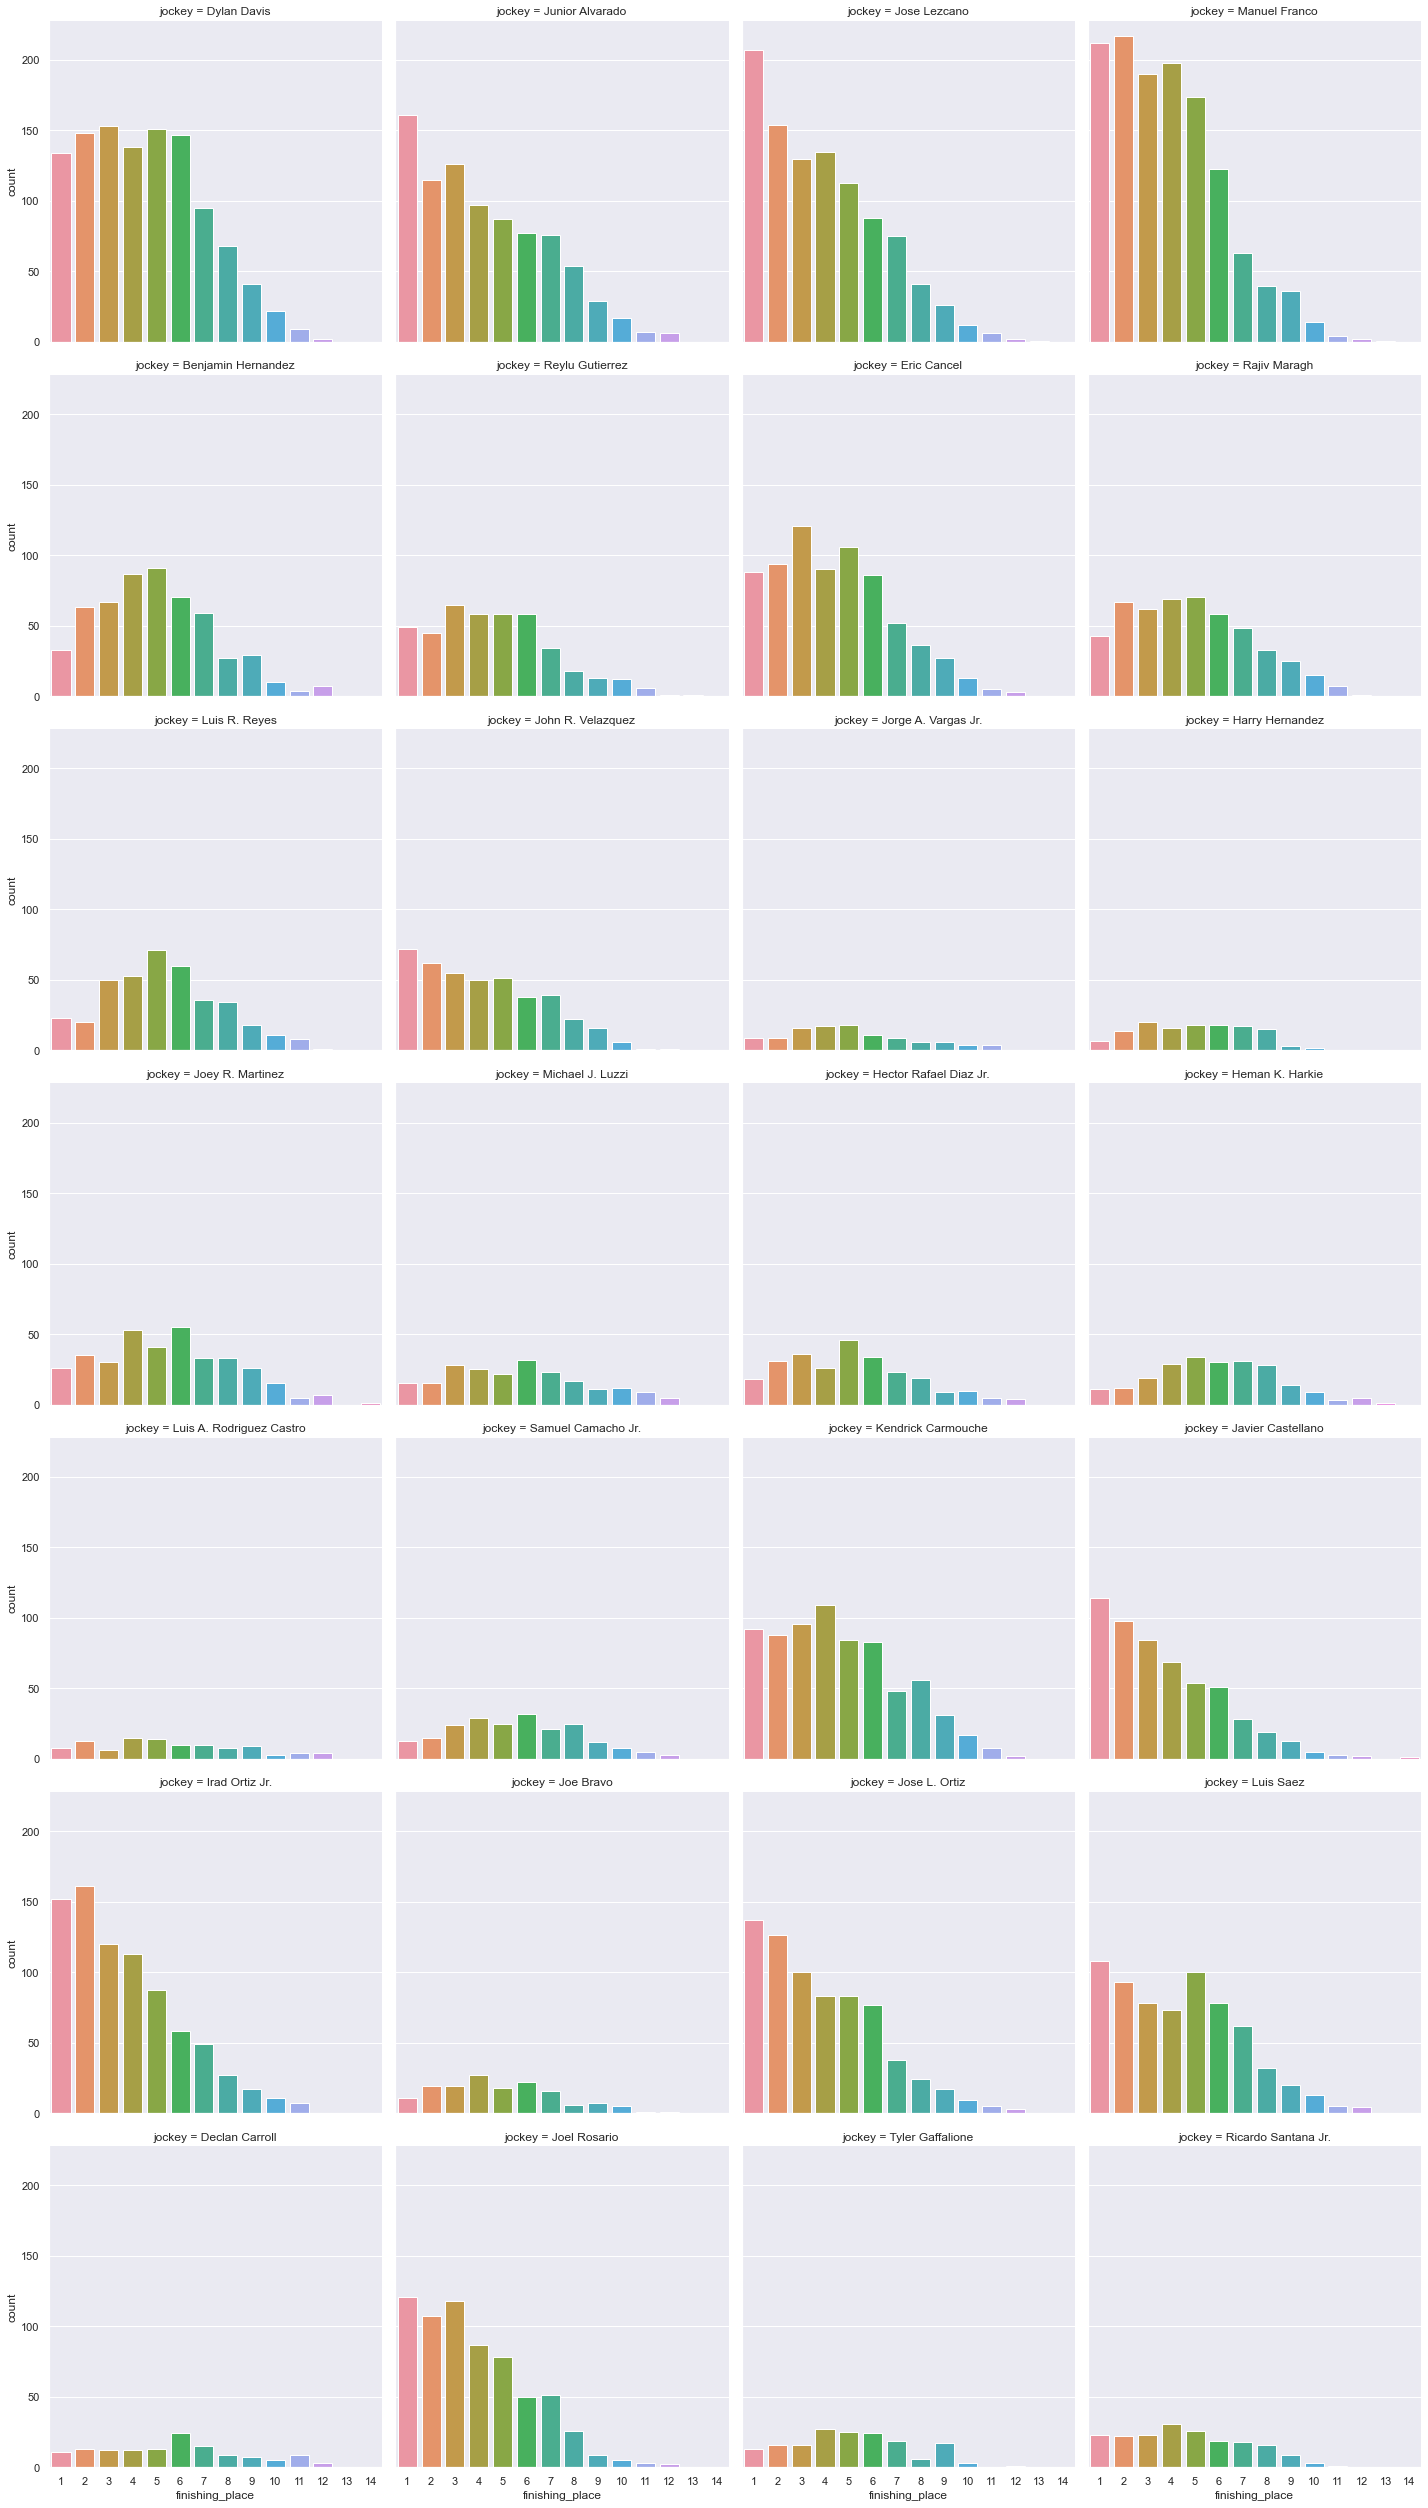

In [88]:
sns.catplot(
     x='finishing_place',
     col='jockey',
     col_wrap=4,
     data=(
         full
         .drop_duplicates(subset=['track_id', 'race_date', 'race_number','program_number'])
         .loc[full['jockey'].isin(freq_riders['jockey_name'])]),
    kind='count'
    );